# Pearson Residues Example
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 500000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import scanpy as sc
import anndata
import cupy as cp

import time
import rapids_singlecell as rsc
from rapids_singlecell.cunnData import cunnData

import warnings
warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)


## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/500000.h5ad")
adata.var_names_make_unique()

CPU times: user 637 ms, sys: 7.7 s, total: 8.34 s
Wall time: 21.5 s


In [5]:
adata.shape

(500000, 27998)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [6]:
%%time
cudata = cunnData(adata=adata)

CPU times: user 1.85 s, sys: 2.86 s, total: 4.71 s
Wall time: 4.77 s


Verify the shape of the resulting sparse matrix:

In [7]:
cudata.shape

(500000, 27998)

And the number of non-zero values in the matrix:

In [8]:
cudata.nnz

1018936313

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 26.321789741516113


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 5.03 ms, sys: 62 µs, total: 5.09 ms
Wall time: 4.95 ms


In [12]:
%%time
rsc.pp.calculate_qc_metrics(cudata,qc_vars=["MT"])

CPU times: user 152 ms, sys: 13.7 ms, total: 166 ms
Wall time: 236 ms


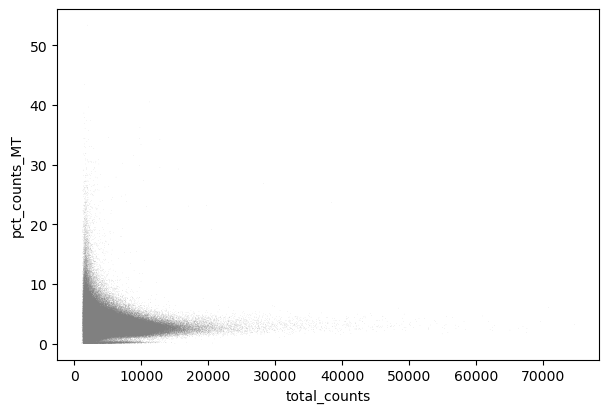

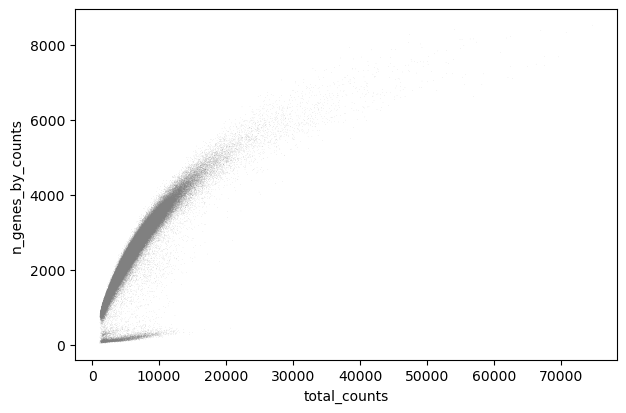

In [13]:
sc.pl.scatter(cudata,"total_counts","pct_counts_MT")
sc.pl.scatter(cudata,"total_counts","n_genes_by_counts")

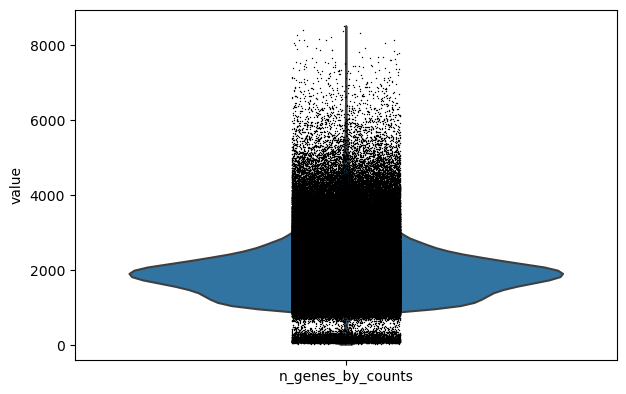

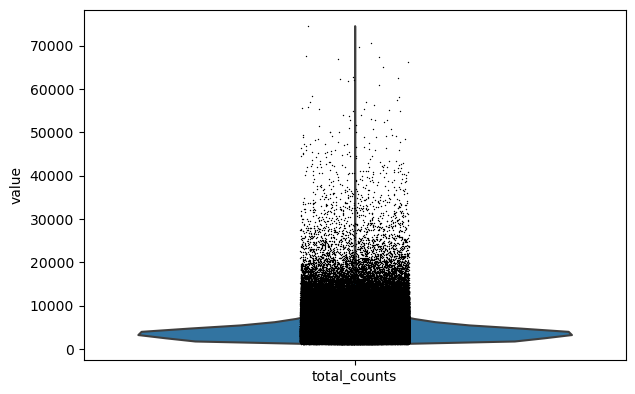

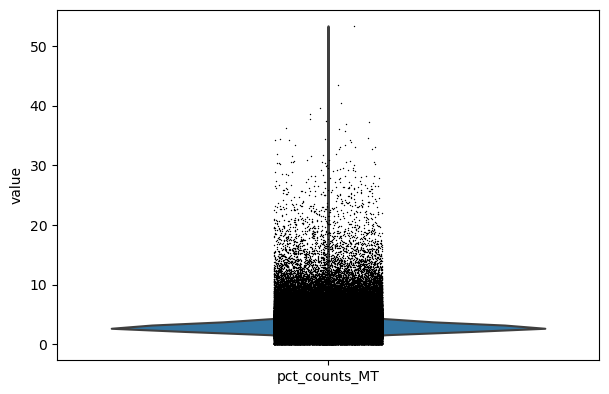

In [14]:
sc.pl.violin(cudata,keys="n_genes_by_counts")
sc.pl.violin(cudata,keys="total_counts")
sc.pl.violin(cudata,keys="pct_counts_MT")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

The size of our count matrix is now reduced.

In [15]:
%%time
rsc.pp.filter_genes(cudata, min_count=10)

filtered out 7663 genes based on n_cells_by_counts
CPU times: user 482 ms, sys: 87 ms, total: 569 ms
Wall time: 584 ms


In [16]:
%%time
rsc.pp.filter_cells(cudata,qc_var="n_genes_by_counts", min_count=500,max_count= 4000)
rsc.pp.filter_cells(cudata,qc_var="total_counts", max_count= 20000)
cudata = cudata[cudata.obs["pct_counts_MT"] < 20]

filtered out 15868 cells
filtered out 5 cells
CPU times: user 484 ms, sys: 128 ms, total: 613 ms
Wall time: 884 ms


We copy the raw counts to the layer `counts`

In [17]:
cudata.layers["counts"] = cudata.X.copy()

### Log-Normalize counts

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [18]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 8.03 ms, sys: 13 ms, total: 21 ms
Wall time: 201 ms


Next, we log transform the count matrix.

In [19]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 9.84 ms, sys: 25.8 ms, total: 35.7 ms
Wall time: 408 ms


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [20]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 1.48 s, sys: 1.09 s, total: 2.57 s
Wall time: 2.57 s


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `pearson_residuals` for selecting highly variable genes with `.layers["counts"]`

In [21]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="pearson_residuals",layer = "counts")

CPU times: user 3.01 s, sys: 109 ms, total: 3.12 s
Wall time: 3.18 s


Now we restrict our cunndata object to the highly variable genes.

In [22]:
%%time
rsc.pp.filter_highly_variable(cudata)

CPU times: user 490 ms, sys: 77.8 ms, total: 568 ms
Wall time: 570 ms


In [23]:
cudata.shape

(483846, 5000)

### Normalize

We normalize the raw counts matrix with pearson_residuals.

In [24]:
%%time
cudata.layers["pearson_residuals"] = rsc.pp.normalize_pearson_residuals(cudata,layer= "counts",inplace = False)

CPU times: user 1 s, sys: 27.9 ms, total: 1.03 s
Wall time: 1.05 s


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 150 principal components. We use the PCA implementation from cuMLs.

We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

In [25]:
%%time
rsc.pp.pca(cudata, n_comps = 150, layer = "pearson_residuals")

CPU times: user 3.2 s, sys: 441 ms, total: 3.64 s
Wall time: 4.31 s


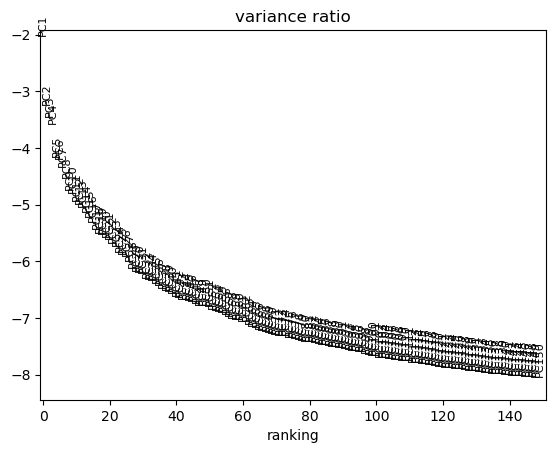

In [26]:
sc.pl.pca_variance_ratio(cudata, log=True,n_pcs=150)

Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [27]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata

CPU times: user 2.06 s, sys: 1.61 s, total: 3.67 s
Wall time: 3.68 s


In [28]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 25.765259742736816


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [29]:
%%time
rsc.tl.neighbors(adata, n_neighbors=15, n_pcs=60)

CPU times: user 5 s, sys: 126 ms, total: 5.13 s
Wall time: 5.15 s


Next we calculate the UMAP embedding using rapdis.

In [30]:
%%time
rsc.tl.umap(adata)

CPU times: user 6.41 s, sys: 49.7 ms, total: 6.46 s
Wall time: 6.46 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [31]:
%%time
rsc.tl.louvain(adata,resolution=1.0)

CPU times: user 1.24 s, sys: 2.86 s, total: 4.1 s
Wall time: 4.23 s


In [32]:
%%time
rsc.tl.leiden(adata,resolution=1.0)

CPU times: user 1.33 s, sys: 3.23 s, total: 4.57 s
Wall time: 4.58 s


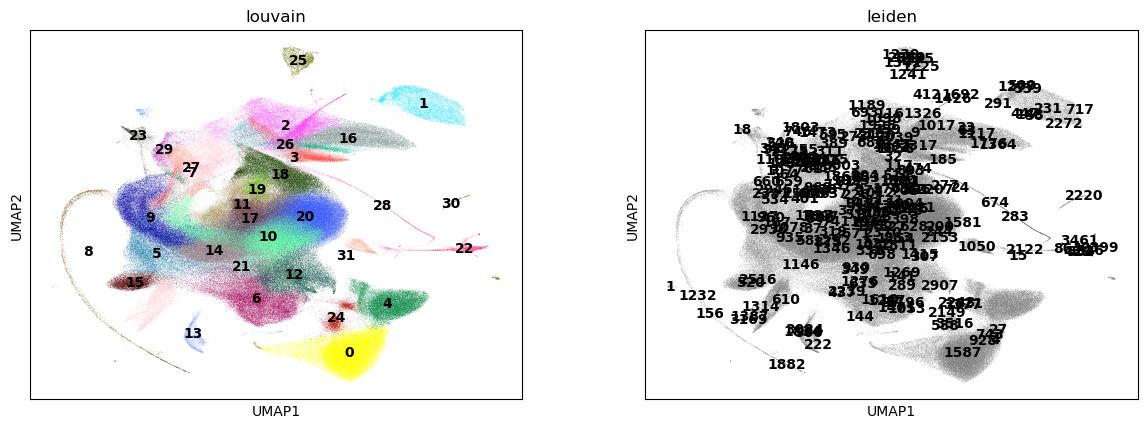

CPU times: user 3.11 s, sys: 537 ms, total: 3.64 s
Wall time: 3.47 s


In [33]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

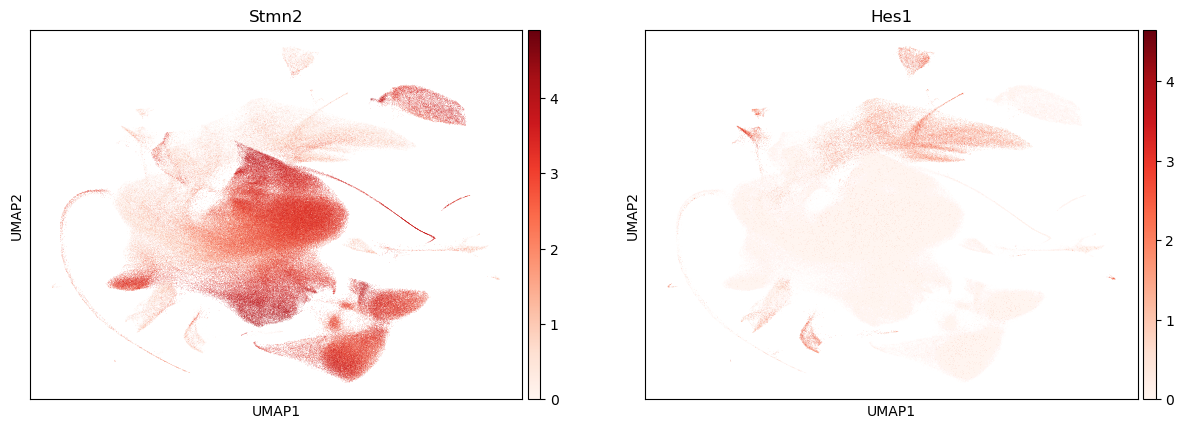

CPU times: user 3.37 s, sys: 322 ms, total: 3.69 s
Wall time: 3.52 s


In [34]:
%%time
sc.pl.umap(adata, color=["Stmn2","Hes1"],legend_loc = 'on data', cmap="Reds")

In [35]:
%%time
rsc.tl.diffmap(adata)

CPU times: user 3.25 s, sys: 11 s, total: 14.3 s
Wall time: 1.3 s


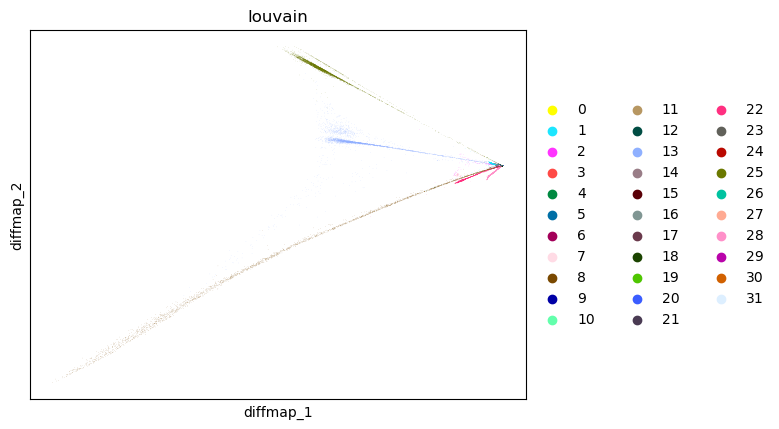

In [36]:
adata.obsm["X_diffmap_"] = adata.obsm["X_diffmap"][:, 1:] 
sc.pl.embedding(adata, "diffmap_", color="louvain")

In [37]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="louvain", use_raw=False)

[W] [16:24:54.188618] L-BFGS: max iterations reached
[W] [16:24:54.189657] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 57.7 s, sys: 3.72 s, total: 1min 1s
Wall time: 1min 1s


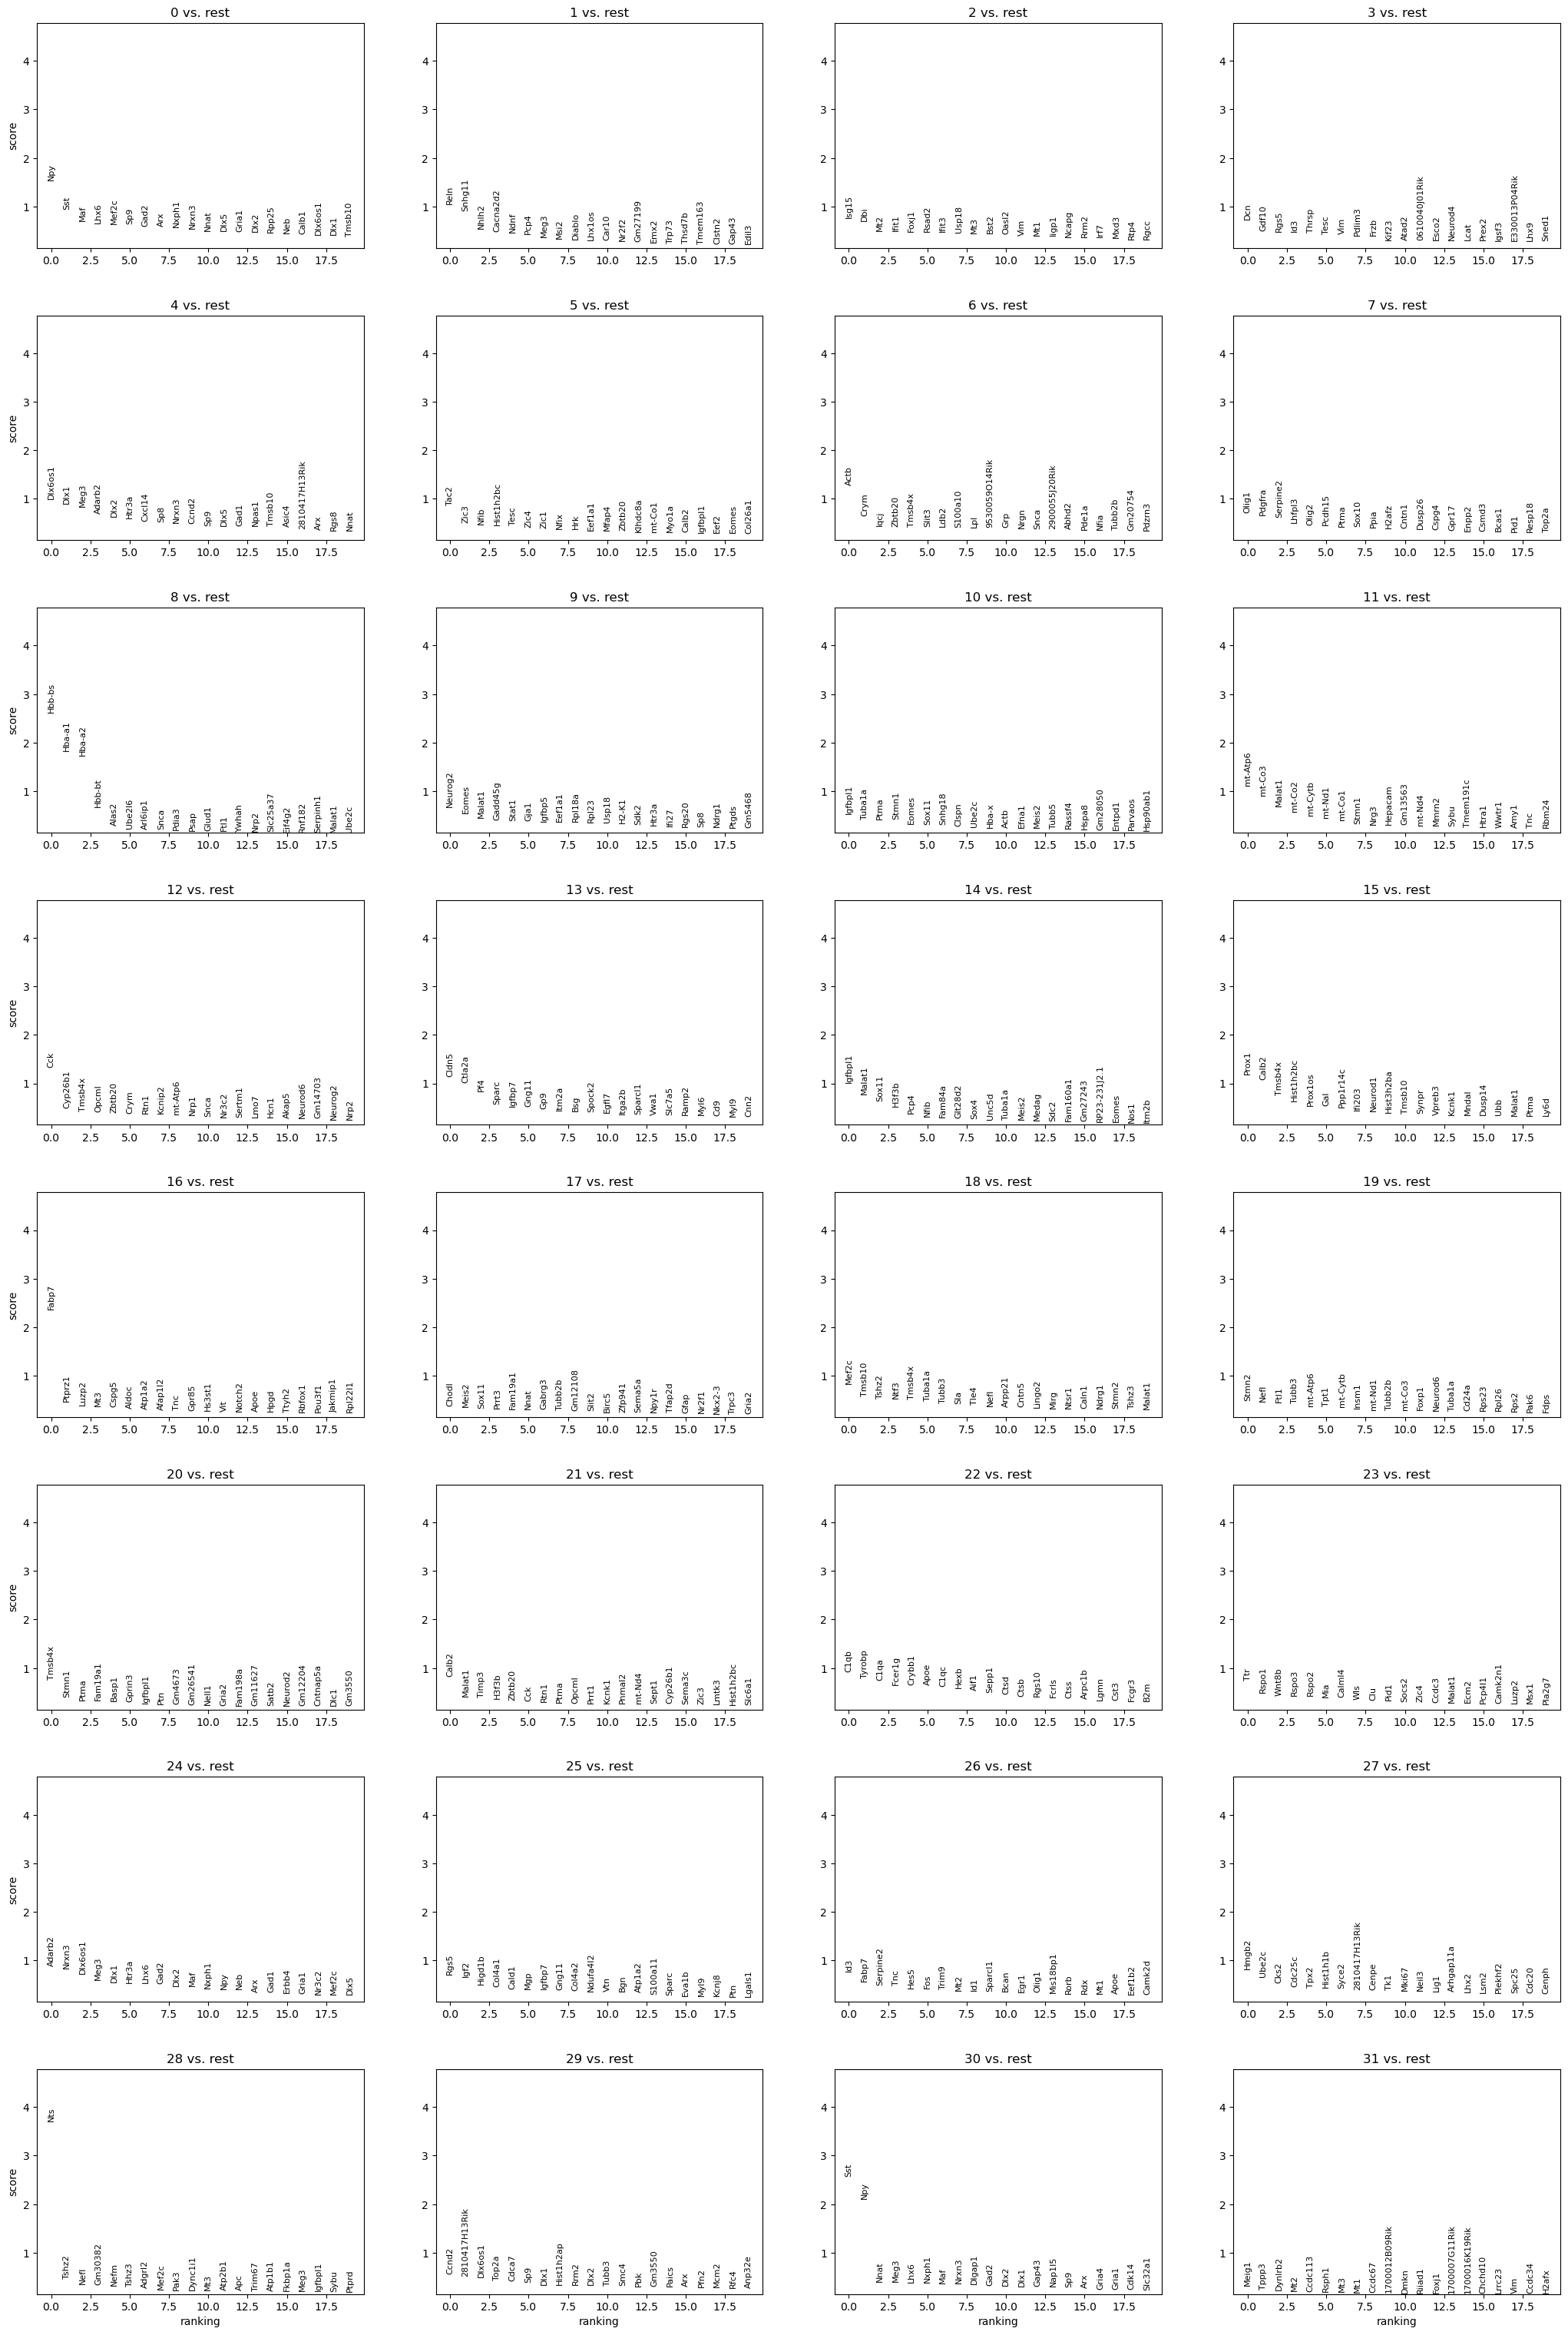

CPU times: user 3.25 s, sys: 238 ms, total: 3.49 s
Wall time: 3.32 s


In [38]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [39]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 120.97854590415955
